### Set up your path and CUDA devices so that you can use the CMS_Deep_Learning library you have cloned in your home directory, and use a particular GPU.

In [1]:
%matplotlib inline
if __package__ is None:
    import sys, os
    sys.path.append(os.path.realpath("/nfshome/dweitekamp/CMS_Deep_Learning/"))
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
import theano
print(theano.__version__)
#Indicies are in alphabetical order
QCD, TTBAR, WJETS = 0,1,2;

Couldn't import dot_parser, loading of dot files will not be possible.


Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0C:00.0)


0.9.0


### Don't worry about this... This is simply grabs the trained models I want from an archive. 

In [5]:
from CMS_Deep_Learning.storage.archiving import *
from CMS_Deep_Learning.postprocessing.colors import colors_contrasting1
from CMS_Deep_Learning.postprocessing.analysistools import sortOnMetric,findWithMetrics
from CMS_Deep_Learning.layers.standardize import Standardize

import numpy as np
os.environ["DELPHES_DIR"] = "/bigdata/shared/Delphes"


########Grab GRU Trial Wrapper###########
from CMS_Deep_Learning.storage.archiving import *
archive_dir = "/bigdata/shared/Delphes/keras_archive_9_18/"
trials = get_trials_by_name(archive_dir,".",assert_complete=True)
trials = sorted(trials, key=lambda x:x.get_from_record('val_acc'),reverse=True)
#trials = findWithMetrics(trials, {"sort_ascending": False, "sort_on": "MaxLepDeltaR"})
for t in trials:
    print(t.summary())
best_GRU = trials[0]
model_GRU,weights_GRU = best_GRU.model,best_GRU.get_path()+"/weights.h5"
print(best_GRU.summary())



########Grab LSTM Trial Wrapper###########
archive_dir = "/bigdata/shared/Delphes/keras_archive_7_9/"
trials = get_trials_by_name(archive_dir,"LSTM",assert_complete=True)
trials = sorted(trials, key=lambda x:x.get_from_record('val_acc'),reverse=True)
trials = findWithMetrics(trials, { "sort_ascending": False, "sort_on": "MaxLepDeltaR"})
best_LSTM = trials[1]
model_LSTM,weights_LSTM = best_LSTM.model,best_LSTM.get_path()+"/weights.h5"
print(best_LSTM.summary())

    

--------------------------------------------------
TRIAL SUMMARY (62e710bc15349faf20b6d06feb1a6349cad64ddf)
    Record_Info:
        name = ["GRU"], elapse_time = 12:26:19, last_epoch = 33, start_time = "09-19-2017 09:34:49 PST-PDT"
        val_acc = 0.9459
        num_train = 300000, num_validation = 37500
        activation = "tanh", depth = 1, labels = ["qcd", "ttbar", "wjets"], n_train_files = 40, patience = 8, recurrent_width = 50, sort_ascending = true, sort_on = "MaxLepDeltaR"
--------------------------------------------------
--------------------------------------------------
TRIAL SUMMARY (4aaef38ecdf98a640bb82498bee14baced4934c5)
    Record_Info:
        name = ["GRU"], elapse_time = 11:48:03, last_epoch = 32, start_time = "09-19-2017 11:14:30 PST-PDT"
        val_acc = 0.9452
        num_train = 300000, num_validation = 37500
        activation = "tanh", depth = 1, labels = ["qcd", "ttbar", "wjets"], n_train_files = 40, patience = 8, recurrent_width = 50, sort_ascending = tr

### Get the Predictions and Targets however you like. This is a simple way that will work with any keras model as long as you have the path to your model.json and weights.h5, and a directory path for the dataset.

In [3]:
from CMS_Deep_Learning.io import simple_grab,repr_structure
val_dir = '/bigdata/shared/Delphes/np_datasets_new/3_way/MaxLepDeltaR_des/val'
GRU_targets,GRU_predictions  = simple_grab(["Y","predictions"],
                                   data=val_dir,
                                   input_keys='Particles',
                                   label_keys='Labels',
                                    model=model_GRU,
                                    weights=weights_GRU,
                                    custom_objects={'Standardize':Standardize}
                                  )
GRU_HLF = simple_grab("X",
                   data=val_dir,
                   input_keys='HLF'
                  )

val_dir = '/bigdata/shared/Delphes/np_datasets_old1/3_way/MaxLepDeltaR_des/val'
LSTM_targets,LSTM_predictions = simple_grab(["Y","predictions"],
                                   data=val_dir,
                                   input_keys='Particles',
                                   label_keys='Labels',
                                    model=model_LSTM,
                                    weights=weights_LSTM,
                                    custom_objects={'Standardize':Standardize}        
                                  )
LSTM_HLF = simple_grab("X",
                   data=val_dir,
                   input_keys='HLF'
                  )
print(GRU_predictions.shape, GRU_targets.shape,LSTM_predictions.shape, LSTM_targets.shape)
print(GRU_HLF.shape, LSTM_HLF.shape)

((52500, 3), (52500, 3), (37500, 3), (37500, 3))
((52500, 14), (37500, 6))


### Grab the ROC data: (fpr,tpr, thresholds (optional), AUC)

In [4]:
#plot_roc_curve(trial=best, true_class_index=1, title="",custom_objects={'Standardize':Standardize})
from CMS_Deep_Learning.postprocessing.metrics import get_roc_data
ROC_data_GRU =get_roc_data(
                predictions=GRU_predictions,
                Y=GRU_targets,
               true_class_index=TTBAR,
               
                )


ROC_data_LSTM =get_roc_data(
                predictions=LSTM_predictions,
                Y=LSTM_targets, 
                true_class_index=TTBAR,
                )


### Plot the ROC Curves

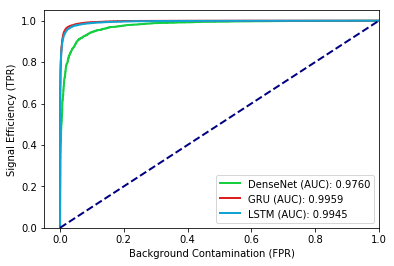

In [5]:
from CMS_Deep_Learning.postprocessing.plot import plot_roc_curve
import h5py
f = h5py.File("/nfshome/thong/LCDJets/EventImage_ROC.h5")
ROC_data_DenseNet = f["FPR"],f["TPR"], None,.976

args = [{"name" :'DenseNet', "ROC_data": ROC_data_DenseNet},
       {"name" :'GRU', "ROC_data": ROC_data_GRU},
       {"name" :'LSTM', "ROC_data": ROC_data_LSTM}]


#rcParams['figure.figsize'] = 7, 7
plt,_ = plot_roc_curve(args,
               title="",
               xlabel="Background Contamination (FPR)",
               ylabel="Signal Efficiency (TPR)",
               show=False)


### Get a table of the efficiencies and contamination rates (separated by class) for a set of fixed points.

In [6]:
from CMS_Deep_Learning.postprocessing.metrics import get_roc_points
import pandas as pd
class_labels = {QCD:'QCD',TTBAR:r'$t\bar{t}$', WJETS:"W+jets"}
fix_tprs = []
fix_fprs = []

GRU_ROC_points = get_roc_points(
                    Y=GRU_targets,
                    predictions=GRU_predictions,
                    class_labels=class_labels,
                    true_class_index=TTBAR,
                    tpr=fix_tprs,
                    fpr=fix_fprs,
                    class_fprs = {QCD: [.0001,.00025,.0005,.001, .0015,.002, .0025,.005,.01,.025,.05,.075,.1]})
GRU_ROC_points = pd.DataFrame(GRU_ROC_points, columns=['tpr','fpr','fpr:W+jets','fpr:QCD', 'thresh'])
GRU_ROC_points.to_hdf("GRU_ROC_points.h5","ROC_Points")

print("GRU: TPRS and FPRS in percents(%)")
print(100*GRU_ROC_points)


LSTM_ROC_points = get_roc_points(
                    Y=LSTM_targets,
                    predictions=LSTM_predictions,
                    class_labels=class_labels,
                    true_class_index=TTBAR,
                    tpr=fix_tprs,
                    fpr=fix_fprs,
                    class_fprs = {QCD: [.0001,.00025,.0005,.001, .0015,.002, .0025,.005,.01,.025,.05,.075,.1]})
LSTM_ROC_points = pd.DataFrame(GRU_ROC_points, columns=['tpr','fpr','fpr:W+jets','fpr:QCD', 'thresh'])
LSTM_ROC_points.to_hdf("LSTM_ROC_points.h5","ROC_Points")

print("\n\n")
print("LSTM: TPRs and FPRs in percents(%)")
print(100*LSTM_ROC_points)



GRU: TPRS and FPRS in percents(%)
          tpr       fpr  fpr:W+jets    fpr:QCD     thresh
0   12.120000  0.002857    0.000000   0.005714  99.993767
1   44.434286  0.028571    0.028571   0.028571  99.957077
2   56.062857  0.040000    0.034286   0.045714  99.897659
3   67.102857  0.077143    0.057143   0.097143  99.717041
4   75.400000  0.142857    0.137143   0.148571  99.275681
5   77.651429  0.197143    0.194286   0.200000  99.001335
6   79.154286  0.231429    0.211429   0.251429  98.746384
7   85.988571  0.434286    0.371429   0.497143  95.785545
8   91.165714  0.788571    0.577143   1.000000  87.176743
9   96.474286  2.042857    1.582857   2.502857  44.250427
10  97.914286  4.162857    3.331429   4.994286  17.002283
11  98.737143  6.500000    5.502857   7.497143   8.114186
12  99.165714  8.897143    7.788571  10.005714   4.282937



LSTM: TPRs and FPRs in percents(%)
          tpr       fpr  fpr:W+jets    fpr:QCD     thresh
0   12.120000  0.002857    0.000000   0.005714  99.993767


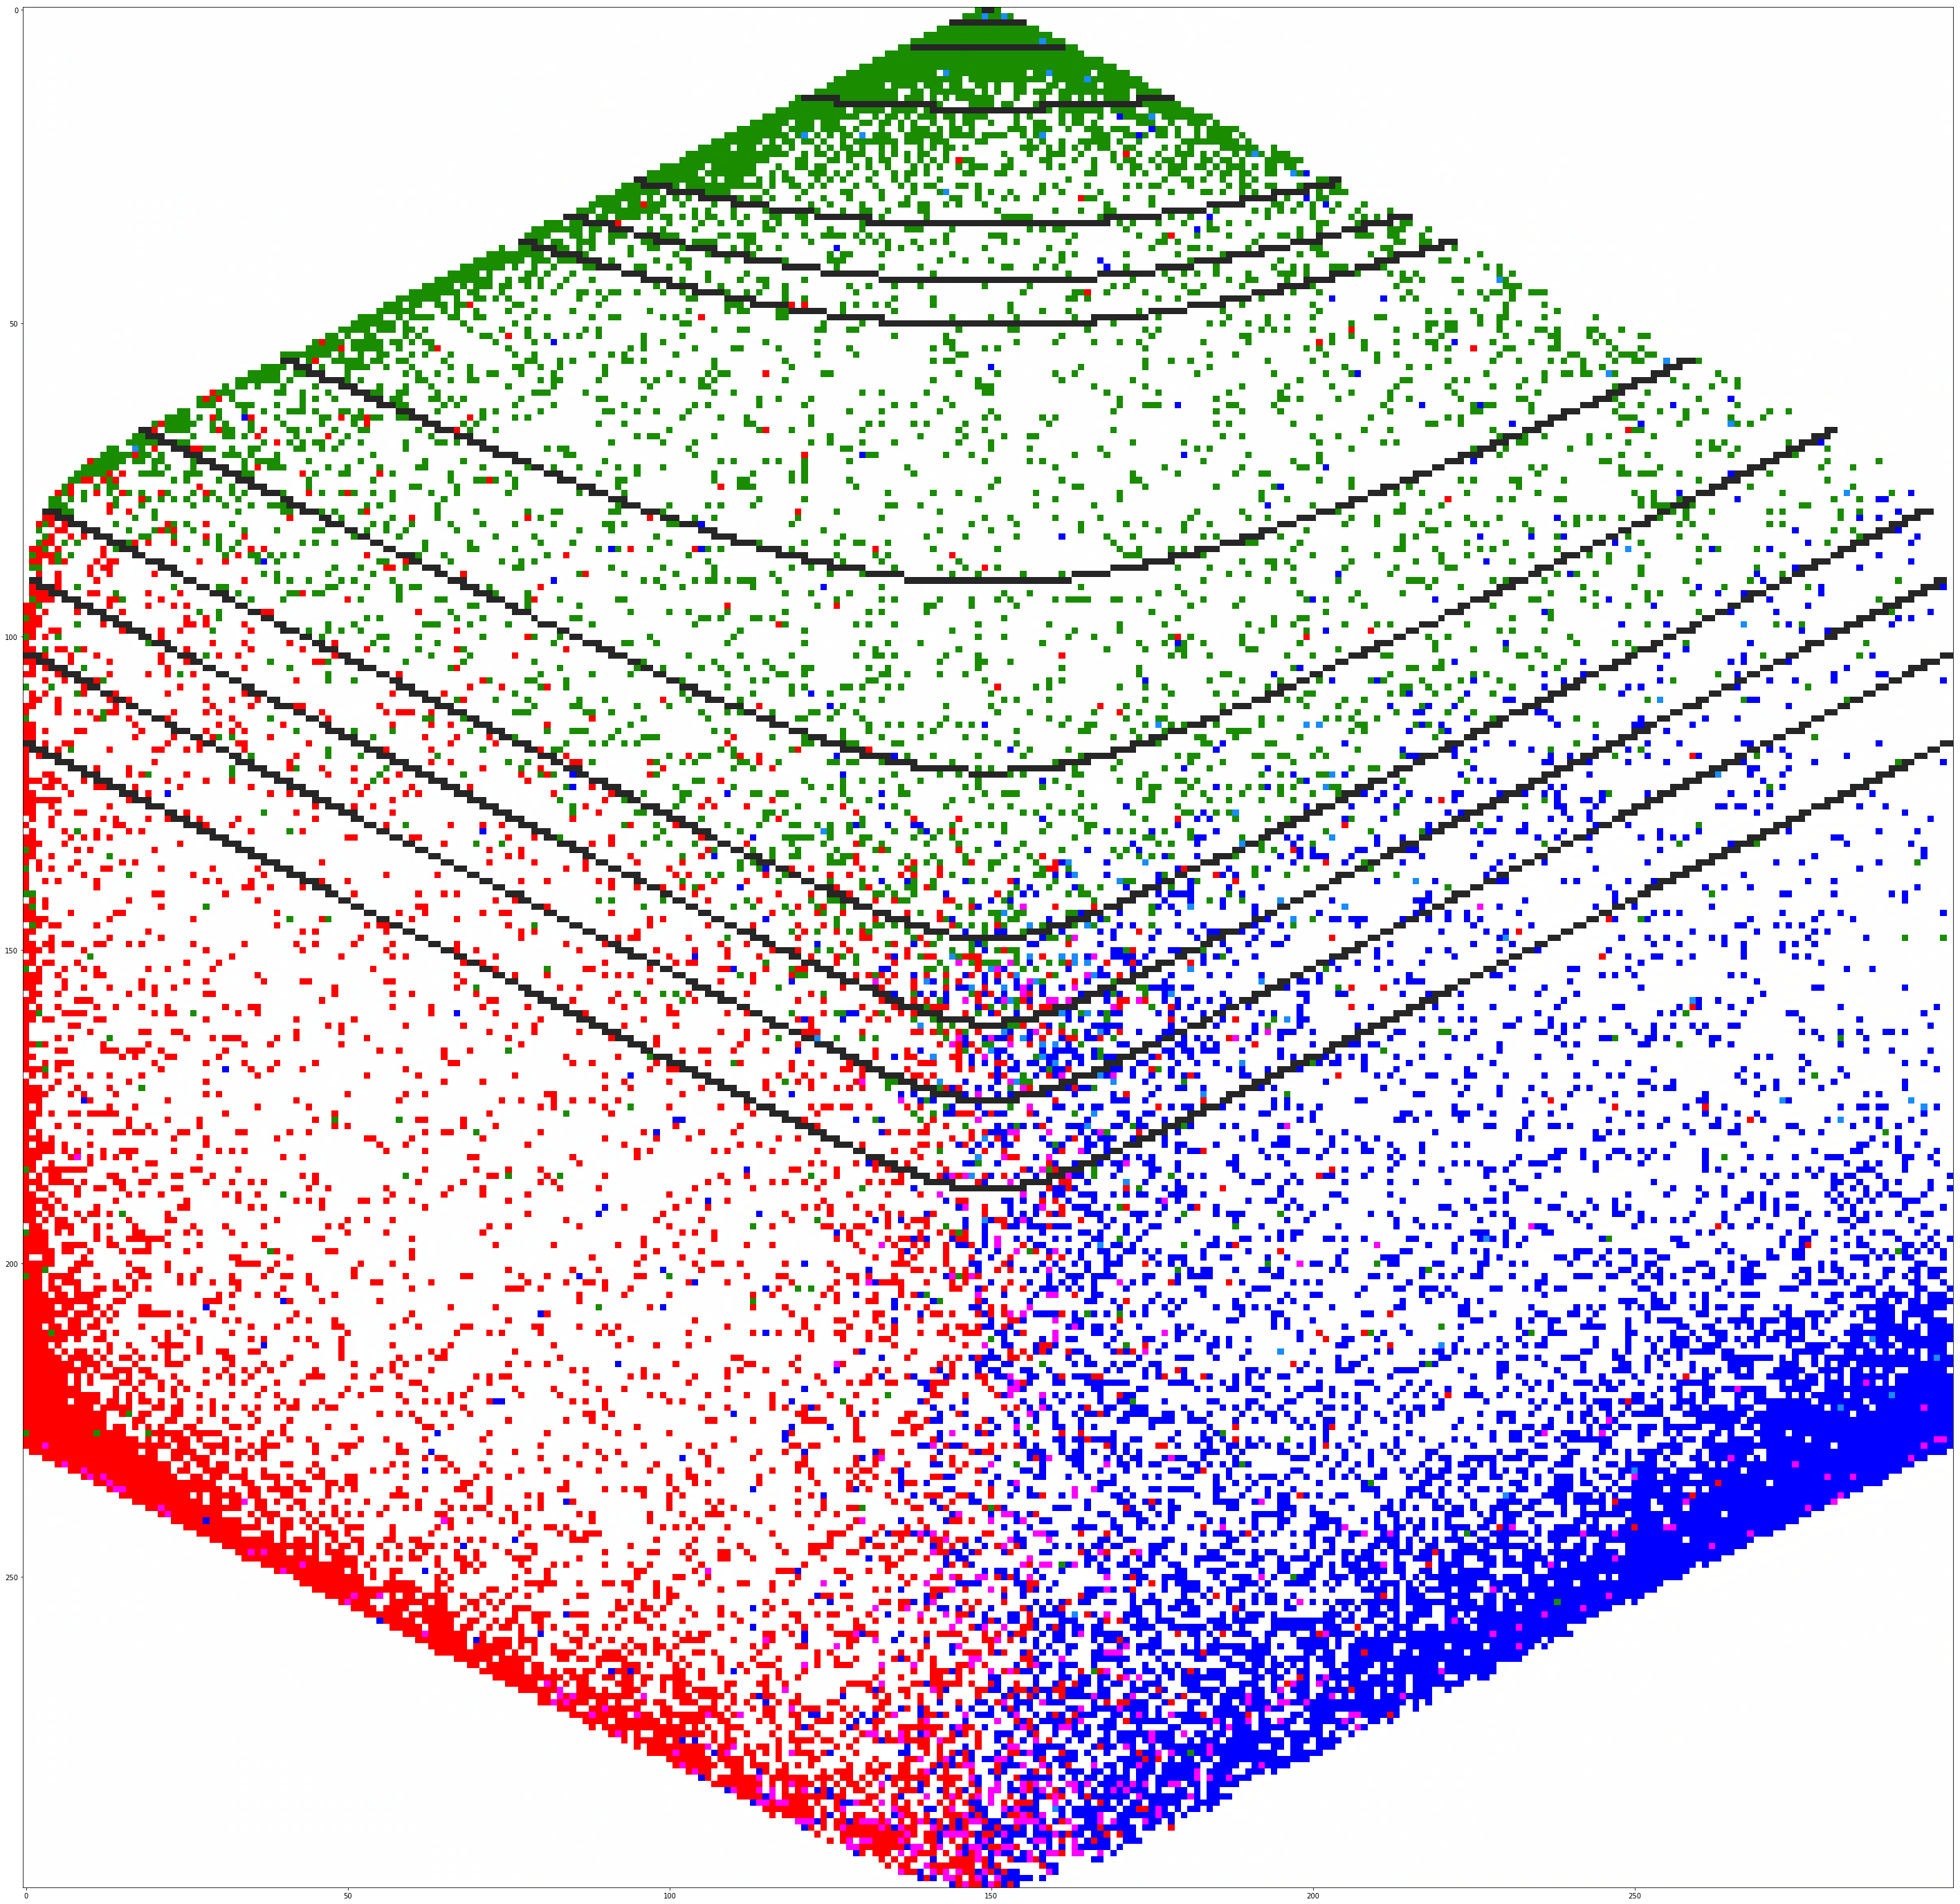

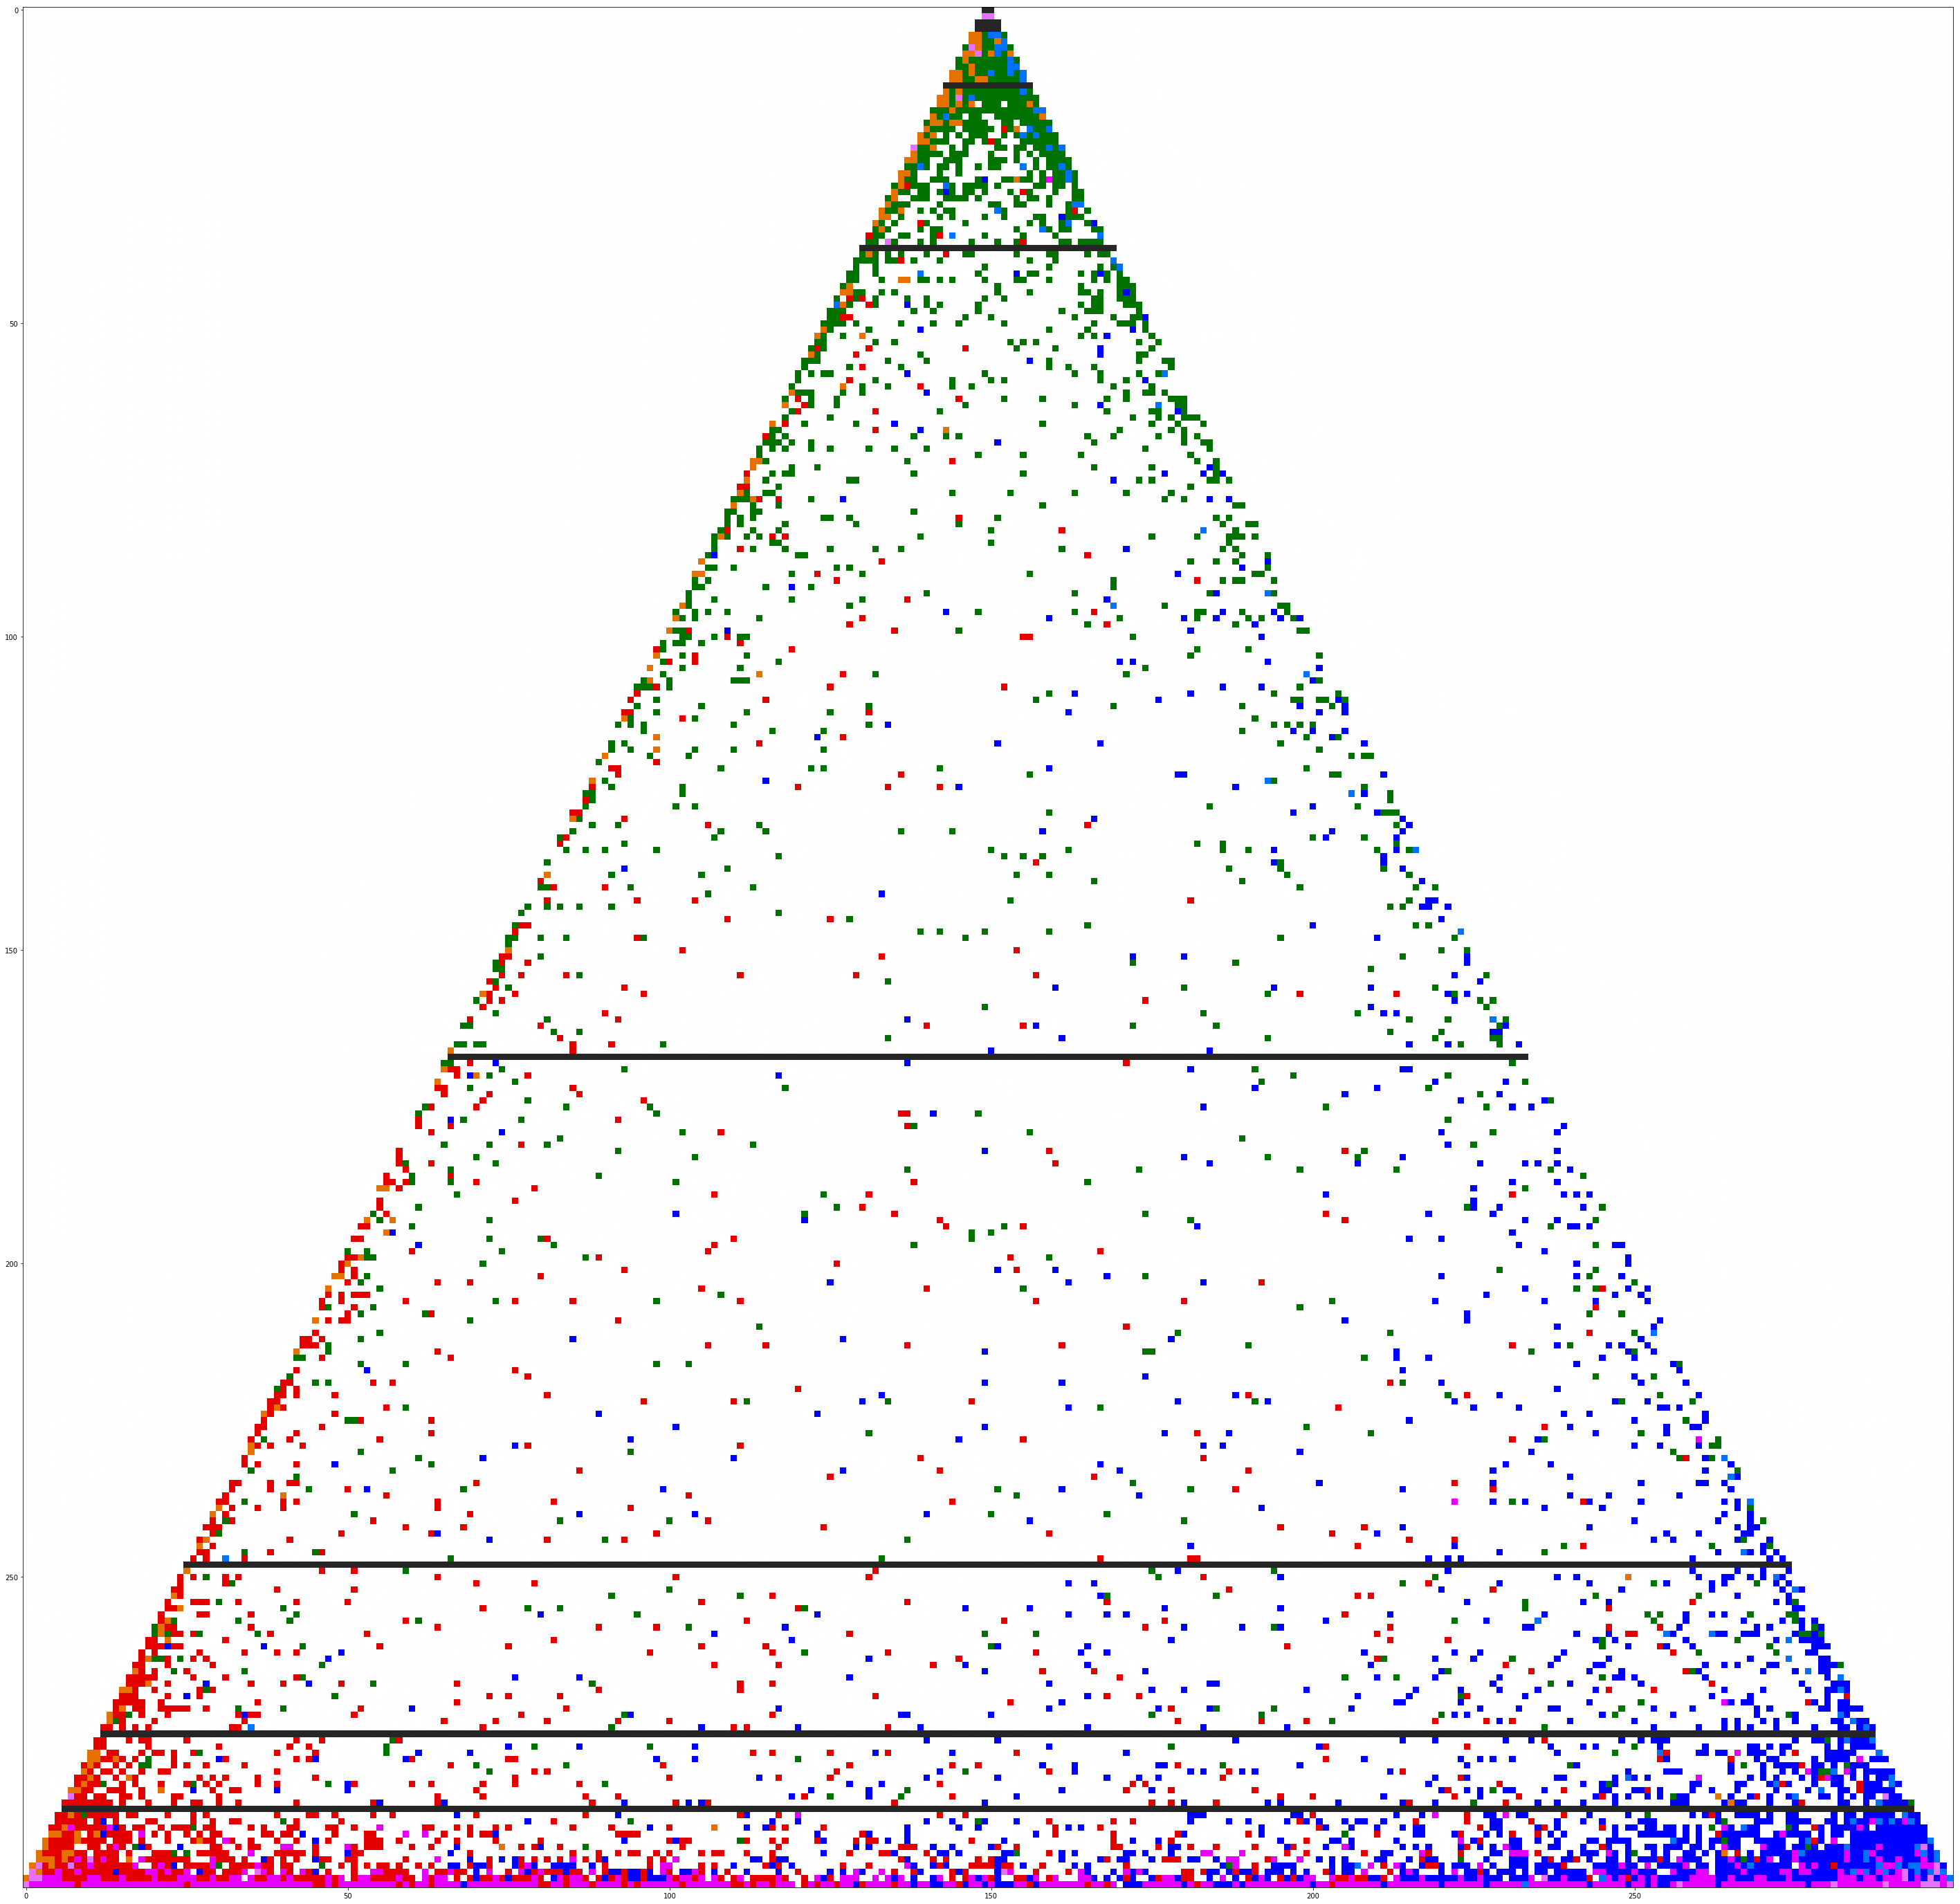

In [7]:
import matplotlib.pyplot as plt
from CMS_Deep_Learning.postprocessing.plot import plot_fano_plane
plt.rcParams['figure.figsize'] = 50, 50

thresholds = [(1,x) for x in GRU_ROC_points["thresh"].tolist()]

plot_fano_plane(GRU_predictions,GRU_targets, index_positions=[TTBAR,QCD,WJETS],index_colors={QCD: (1.0,0.0,0.0), TTBAR: (0.1,0.55,0.0), WJETS: (0.0,0.0,1.0)},
                bin_res=300, thicken_lines=False,log_scale=True, log_intesity=100,
                thresholds=thresholds,
                line_color=(.15,.15,.15),
                background_color='w')

plot_fano_plane(GRU_predictions,GRU_targets, index_positions=[TTBAR,QCD,WJETS],index_colors={QCD: (.9,0,0), TTBAR: (0.0,.45,0.0), WJETS: 'b'},
                bin_res=300, thicken_lines=False,log_scale=False,
                thresholds=thresholds,
                line_color=(.15,.15,.15),
                background_color='w')

In [8]:
from CMS_Deep_Learning.postprocessing.metrics import bin_metric_vs_char
def closest_to(df, key, value):
    return df.iloc[(df[key] - value).abs().argsort()[0]]

lepPt = GRU_HLF[:,6]
lepHt = GRU_HLF[:,0]
lepMET = GRU_HLF[:,1]

lepPtBins = []
lepHtBins = []
lepMETBins = []

for percent in reversed([.1,.25,.5,1,2.5,5]):
    
    thresh = closest_to(GRU_ROC_points, "fpr:QCD",.01*percent)["thresh"]
    
    bins = bin_metric_vs_char(
                    Y=GRU_targets,
                    predictions=GRU_predictions,
                    characteristics=lepPt,
                    true_class_index=TTBAR,
                    threshold=thresh,
                    nb_bins=20)
    lepPtBins.append(("QCD Contamination %.2f%%" % percent,bins))

    bins = bin_metric_vs_char(
                    Y=GRU_targets,
                    predictions=GRU_predictions,
                    characteristics=lepHt,
                    true_class_index=TTBAR,
                    threshold=thresh,
                    nb_bins=20)
    lepHtBins.append(("QCD Contamination %.2f%%" % percent,bins))
    
    bins = bin_metric_vs_char(
                    Y=GRU_targets,
                    predictions=GRU_predictions,
                    characteristics=lepMET,
                    true_class_index=TTBAR,
                    threshold=thresh,
                    nb_bins=20)
    lepMETBins.append(("QCD Contamination %.2f%%" % percent,bins))


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

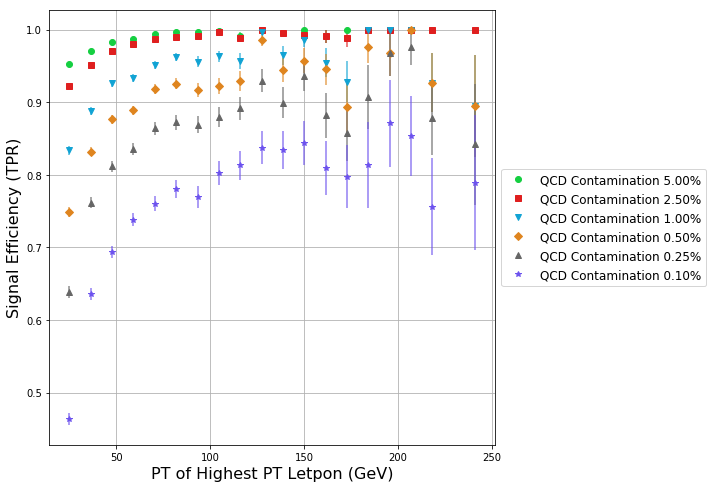

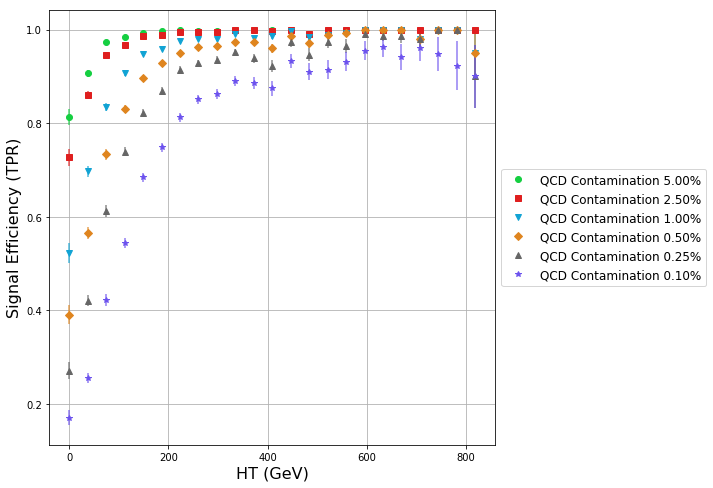

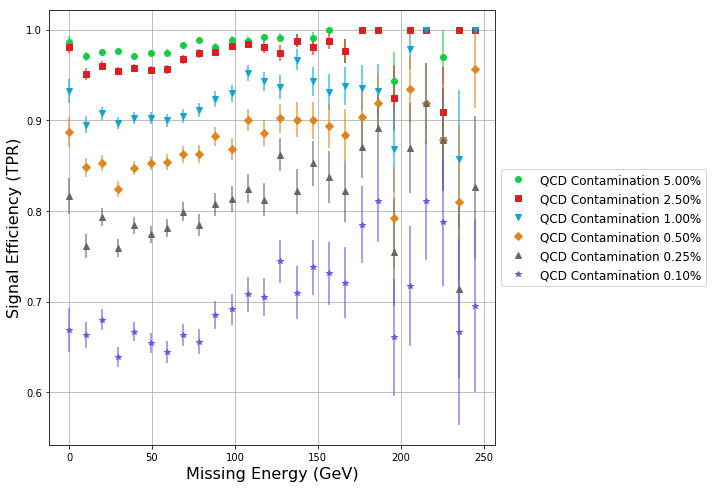

In [9]:
from CMS_Deep_Learning.postprocessing.plot import plot_bins
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = 10, 10
plot_bins(lepPtBins, y_val="tpr",
          mode='scatter',
          class_labels = class_labels,
          xlabel="PT of Highest PT Letpon (GeV)",
          ylabel="Signal Efficiency (TPR)",
          #title='ttbar Efficiency vs. MaxLep PT',
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepHtBins, y_val="tpr",
          mode='scatter',
          class_labels = class_labels,
          xlabel="HT (GeV)",
          ylabel="Signal Efficiency (TPR)",
          #title='ttbar Efficiency vs. HT',
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepMETBins, y_val="tpr",
          mode='scatter',
          class_labels = class_labels,
          xlabel="Missing Energy (GeV)",
          ylabel="Signal Efficiency (TPR)",
          #title='ttbar Efficiency vs. MET',
          min_samples=20,
          alpha=.75,show=False)



<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

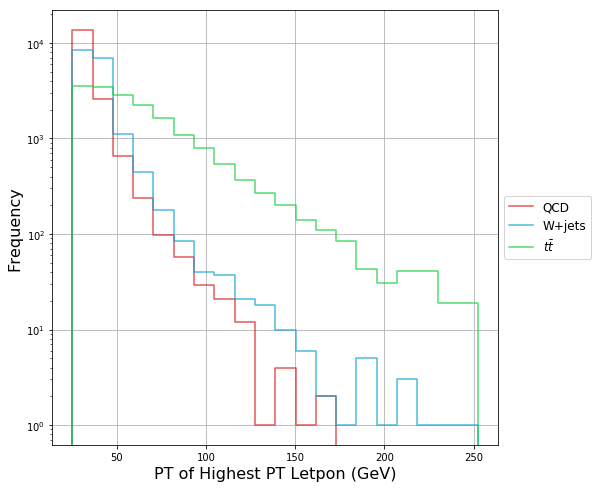

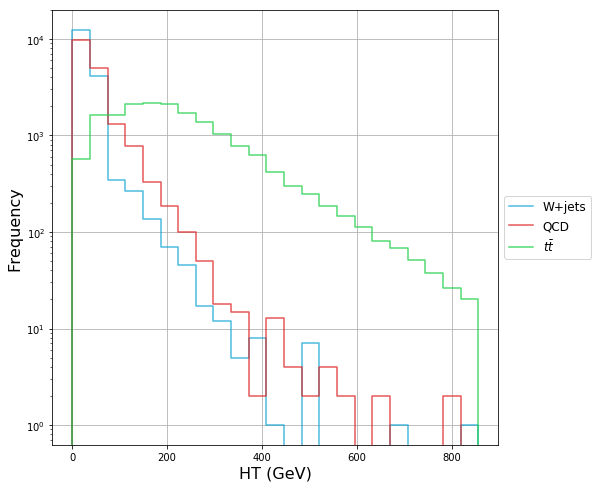

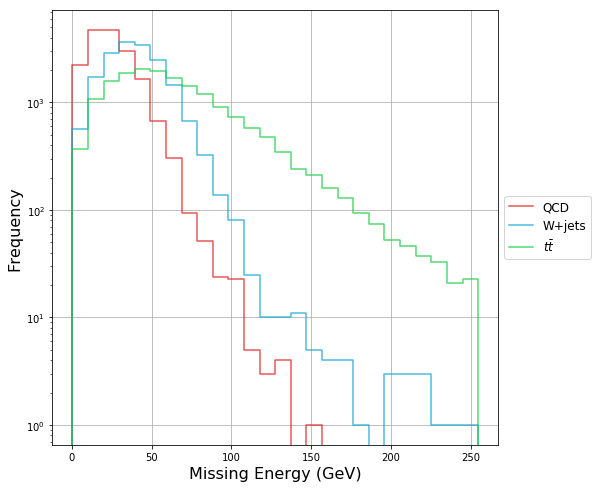

In [14]:
from CMS_Deep_Learning.postprocessing.colors import colors_contrasting1 as cc
r,g,b = [cc[1],cc[0],cc[2]]

plot_bins(lepPtBins[0][1], y_val="freq",
          mode='histo',
          colors = [r,b,g],
          class_labels = class_labels,
          xlabel="PT of Highest PT Letpon (GeV)",
          ylabel="Frequency",
          log=True,
          #title='ttbar Efficiency vs. MaxLep PT',
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepHtBins[0][1], y_val="freq",
          mode='histo',
          colors = [b,r,g],
          class_labels = class_labels,
          xlabel="HT (GeV)",
          ylabel="Frequency",
          log=True,
          #title='ttbar Efficiency vs. HT',
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepMETBins[0][1], y_val="freq",
          mode='histo',
          colors = [r,b,g],
          class_labels = class_labels,
          xlabel="Missing Energy (GeV)",
          ylabel="Frequency",
          log=True,
          #title='ttbar Efficiency vs. MET',
          min_samples=20,
          alpha=.75,show=False)

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

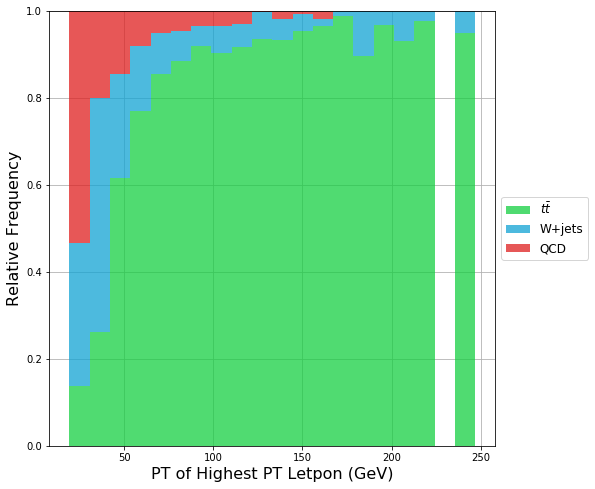

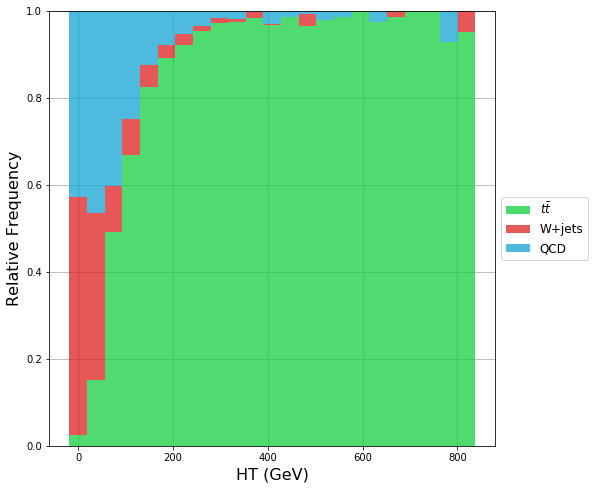

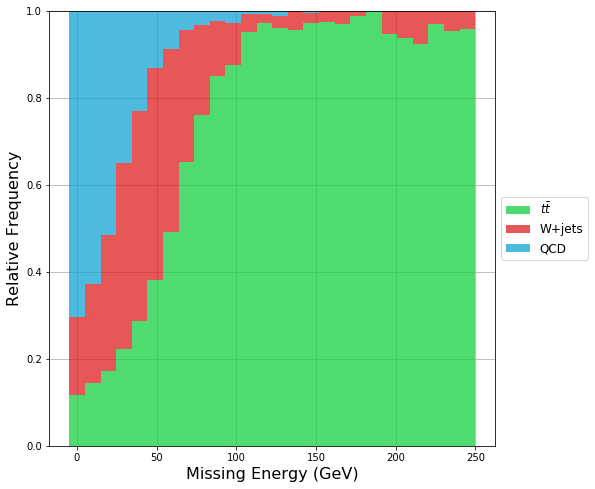

In [15]:
plot_bins(lepPtBins[0][1], y_val="freq",
          mode='histo',
          colors = [g,b,r],
          class_labels = class_labels,
          xlabel="PT of Highest PT Letpon (GeV)",
          ylabel="Relative Frequency",
          stack=True,
          normalize=True,
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepHtBins[0][1], y_val="freq",
          mode='histo',
          colors = [g,r,b],
          class_labels = class_labels,
          xlabel="HT (GeV)",
          ylabel="Relative Frequency",
          stack=True,
          normalize=True,
          min_samples=20,
          alpha=.75,show=False)

plot_bins(lepMETBins[0][1], y_val="freq",
          mode='histo',
          colors = [g,r,b],
          class_labels = class_labels,
          xlabel="Missing Energy (GeV)",
          ylabel="Relative Frequency",
          stack=True,
          normalize=True,
          min_samples=20,
          alpha=.75,show=False)